Uses power and mde lines functionalities to showcase how to plot MDE and power as function of the sample size, given, respectively, the power and the MDE.

In [1]:
from datetime import date

import numpy as np
from cluster_experiments import NormalPowerAnalysis
import pandas as pd
import plotnine as p9

# Create fake data
N = 10_000
clusters = [f"Cluster {i}" for i in range(10)]
dates = [f"{date(2022, 1, i):%Y-%m-%d}" for i in range(1, 15)]
df = pd.DataFrame(
    {
        "cluster": np.random.choice(clusters, size=N),
        "date": np.random.choice(dates, size=N),
    }
).assign(
    # Target is a linear combination of cluster and day of week, plus some noise
    cluster_id=lambda df: df["cluster"].astype("category").cat.codes,
    day_of_week=lambda df: pd.to_datetime(df["date"]).dt.dayofweek,
    target=lambda df: df["cluster_id"] + df["day_of_week"] + np.random.normal(size=N),
    date=lambda df: pd.to_datetime(df["date"]),
)


In [2]:
# Set-up power analysis for switchback experiment
pw_normal = NormalPowerAnalysis.from_dict(
    {
        "splitter": "clustered",
        "analysis": "clustered_ols",
        "cluster_cols": ["cluster", "date"],
        "n_simulations": 5,
        "hypothesis": "two-sided",
        "seed": 20240922,
        "time_col": "date",
    }
)

In [3]:
%%time
# compute power line for different lengths different average effects
power_line = pw_normal.power_time_line(
    df, experiment_length=range(1, 14), average_effects=range(5)
)

CPU times: user 2.06 s, sys: 51.3 ms, total: 2.11 s
Wall time: 2.13 s


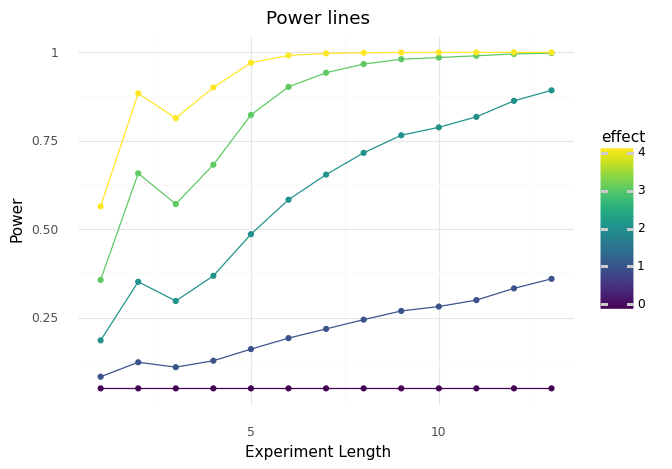

<ggplot: (305797666)>

In [4]:
# plot line
p9.ggplot(
    pd.DataFrame(power_line),
    p9.aes(x="experiment_length", y="power", color="effect", group="effect"),
) + p9.geom_line() + p9.geom_point() + p9.theme_minimal() + p9.labs(
    x="Experiment Length", y="Power"
) + p9.ggtitle("Power lines")

In [5]:
%%time
# compute mde line for different lengths and different powers
mde_line = pw_normal.mde_time_line(
    df, experiment_length=range(1, 14), powers=[0.7, 0.8, 0.9]
)

CPU times: user 1.97 s, sys: 37.7 ms, total: 2 s
Wall time: 2.1 s


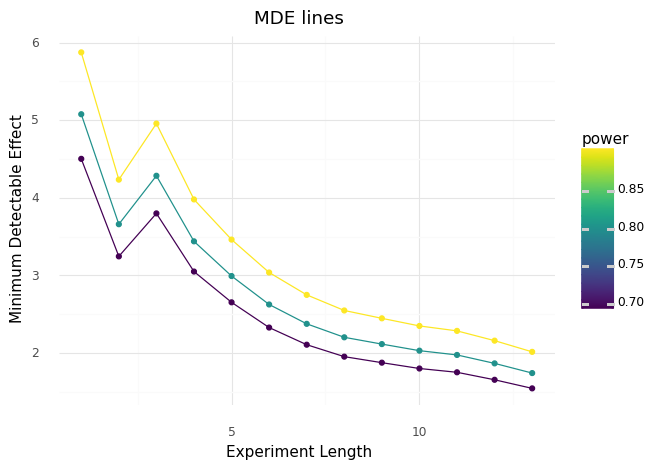

<ggplot: (305795048)>

In [6]:
# plot line
p9.ggplot(
    pd.DataFrame(mde_line),
    p9.aes(x="experiment_length", y="mde", color="power", group="power"),
) + p9.geom_line() + p9.geom_point() + p9.theme_minimal() + p9.labs(
    x="Experiment Length", y="Minimum Detectable Effect"
) + p9.ggtitle("MDE lines")